In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree

In [2]:
try:
    df = pd.read_csv("DDoS_dataset.csv")
    df1 = pd.read_csv("validation_data.csv")
    df2 = pd.read_csv("attack_data_ml.csv") # Carrega o terceiro dataset
    print("Datasets carregado com sucesso!")
    print(f"O dataset base tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
    print(f"O dataset de teste 1 tem {df1.shape[0]} linhas e {df1.shape[1]} colunas.")
    print(f"O dataset de teste 2 tem {df2.shape[0]} linhas e {df2.shape[1]} colunas.")
except FileNotFoundError as e:
    print(f"Erro: Arquivo não encontrado -> {e.filename}")
    exit()


Datasets carregado com sucesso!
O dataset base tem 852585 linhas e 9 colunas.
O dataset de teste 1 tem 34328 linhas e 7 colunas.
O dataset de teste 2 tem 55 linhas e 7 colunas.


In [3]:
# Verifica e remove as colunas de IP de ambos os DataFrames, se existirem
cols_to_drop = ["Source IP", "Dest IP"]
if cols_to_drop[0] in df.columns:
    df = df.drop(cols_to_drop, axis=1)
    print("Colunas de IP removidas do dataset de treino.")

if cols_to_drop[0] in df1.columns:
    df1 = df1.drop(cols_to_drop, axis=1)
    print("Colunas de IP removidas do dataset de validação.")

# Separar as features (X) do nosso alvo (y)
X = df.drop("target", axis=1)
y = df["target"]

# Identificar quais colunas são categóricas e quais são numéricas
categorical_features = ["Highest Layer", "Transport Layer"]
numeric_features = ["Source Port", "Dest Port", "Packet Length", "Packets/Time"]


Colunas de IP removidas do dataset de treino.


In [4]:
all_dfs = [df, df1, df2]
master_categories = []
for feature in categorical_features:
    # Concatena a coluna de todos os dataframes e encontra os valores únicos
    unique_vals = pd.concat([d[feature] for d in all_dfs]).unique()
    master_categories.append(unique_vals)

print(f"\nCategorias unificadas encontradas: {master_categories}")

# Agora, criamos o pré-processador informando explicitamente as categorias.
# Isso garante que a saída terá sempre o mesmo número de colunas.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(categories=master_categories, handle_unknown="ignore"), categorical_features),
    ],
    remainder='passthrough' # Garante que nenhuma coluna seja perdida acidentalmente
)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), numeric_features),
#         ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
#     ]
# )

# Dividir os dados em conjunto de TREINO e conjunto de TESTE.
# 80% para treinar, 20% para testar. random_state garante que a divisão seja sempre a mesma.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Dados divididos em {len(X_train)} amostras de treino e {len(X_test)} de teste.")



Categorias unificadas encontradas: [array(['ARP', 'BOOTP', 'BROWSER', 'DATA', 'DHCPV6', 'LLMNR', 'NBNS',
       'QUIC', 'SSDP', 'TCP', 'UDP'], dtype=object), array(['UDP', 'TCP'], dtype=object)]
Dados divididos em 682068 amostras de treino e 170517 de teste.


In [5]:
model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(max_depth=5, random_state=42)),
    ]
)

# Treinar o modelo! O comando .fit() é onde a "mágica" do aprendizado acontece.
print("\nIniciando o treinamento do modelo...")
model_pipeline.fit(X_train, y_train)
print("Modelo treinado com sucesso!")



Iniciando o treinamento do modelo...
Modelo treinado com sucesso!


In [6]:
print("\nRealizando previsões no conjunto de teste...")
y_pred = model_pipeline.predict(X_test)

# Medir a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do Modelo: {accuracy * 100:.2f}%")


Realizando previsões no conjunto de teste...

Acurácia do Modelo: 99.81%


Gerando a Matriz de Confusão...


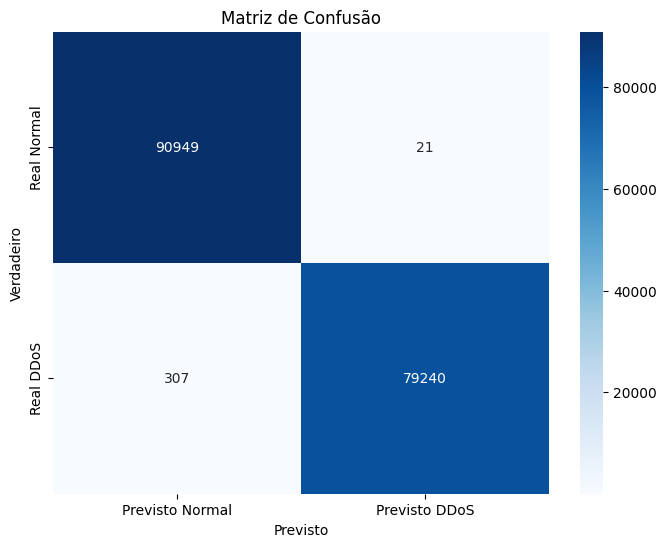

In [7]:
print("Gerando a Matriz de Confusão...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Previsto Normal", "Previsto DDoS"],
    yticklabels=["Real Normal", "Real DDoS"],
)
plt.title("Matriz de Confusão")
plt.ylabel("Verdadeiro")
plt.xlabel("Previsto")
plt.show()  # Exibe o gráfico



Gerando a visualização da Árvore de Decisão...


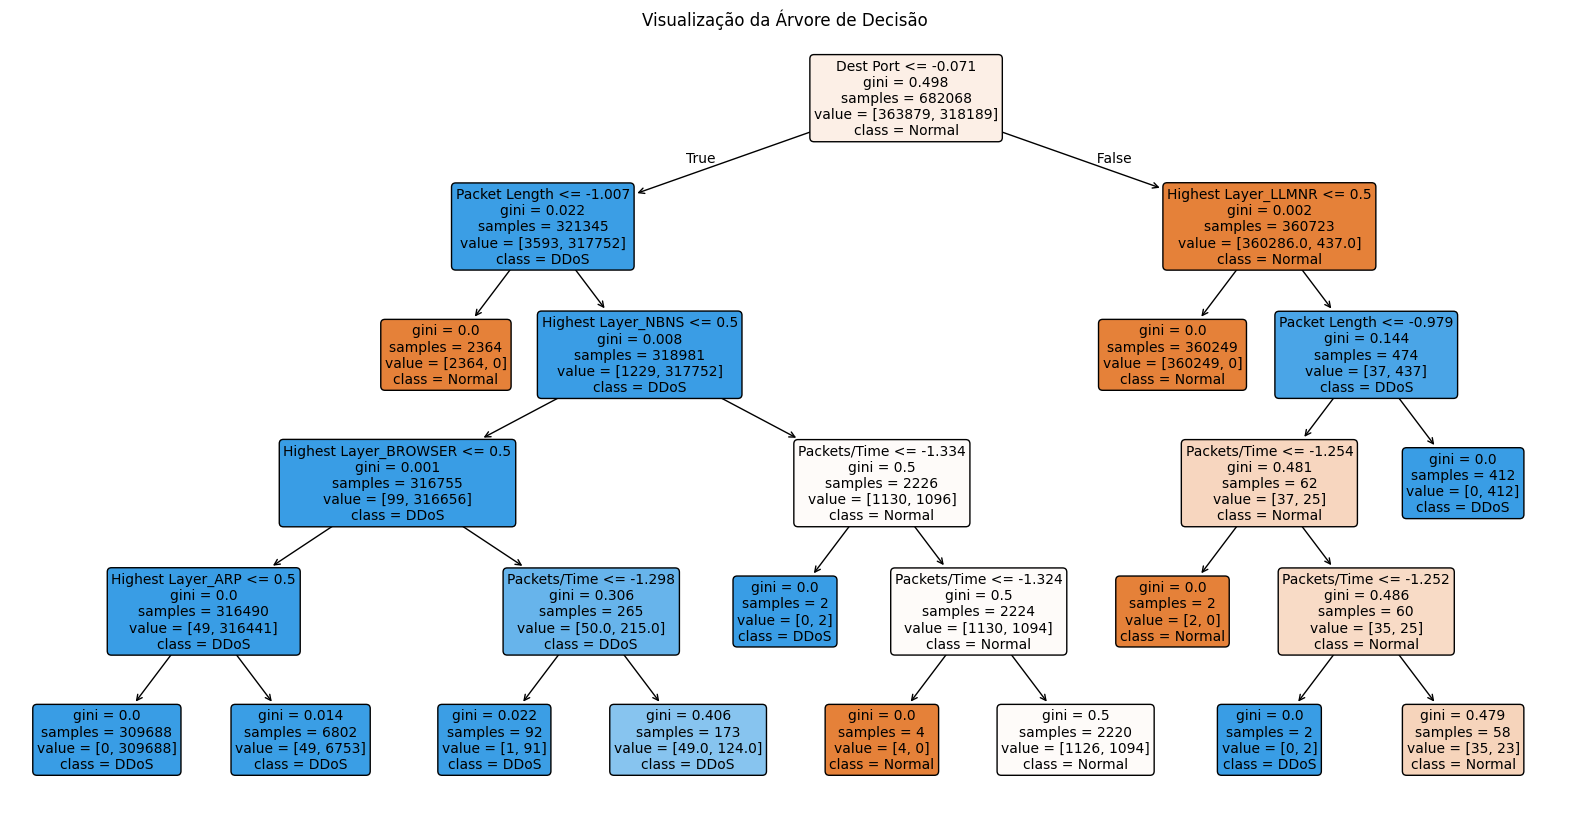

In [8]:

# --- ETAPA 5: Visualização da Árvore de Decisão ---

# Este é um ótimo gráfico para sua apresentação!
print("\nGerando a visualização da Árvore de Decisão...")

# Pegar os nomes das features após o OneHotEncoding para usar no gráfico
feature_names = numeric_features + list(
    model_pipeline.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)

plt.figure(figsize=(20, 10))
plot_tree(
    model_pipeline.named_steps["classifier"],
    feature_names=feature_names,
    class_names=["Normal", "DDoS"],
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("Visualização da Árvore de Decisão")
plt.show()  # Exibe a árvore



INICIANDO VALIDAÇÃO COM O DATASET EXTERNO 'validation_data.csv'

O dataset de validação tem 34328 amostras para teste.
Realizando previsões no novo dataset de validação...
Previsões concluídas.

ACURÁCIA NO DATASET DE VALIDAÇÃO EXTERNO: 0.02%

Relatório de Classificação para o Dataset de Validação Externo:
              precision    recall  f1-score   support

      Normal       0.00      1.00      0.00         6
        DDoS       0.00      0.00      0.00     34322

    accuracy                           0.00     34328
   macro avg       0.00      0.50      0.00     34328
weighted avg       0.00      0.00      0.00     34328

Gerando a Matriz de Confusão para o Dataset de Validação Externo...


/home/guigui/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/guigui/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/guigui/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


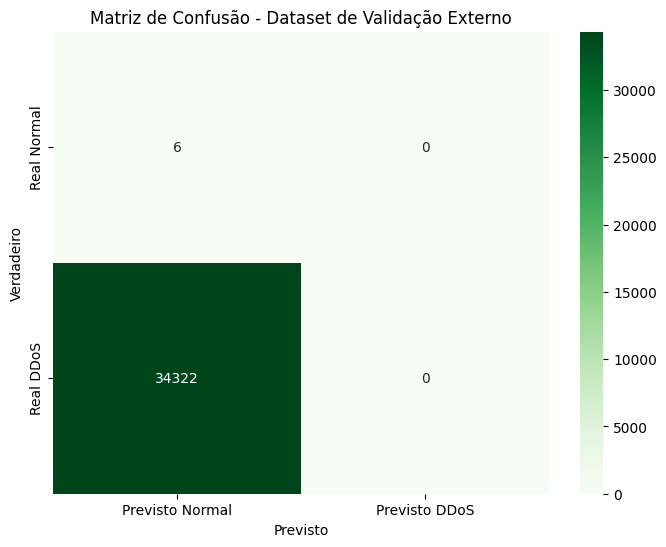

In [9]:
# ==============================================================================
# ==  VALIDAÇÃO DO MODELO COM O NOVO DATASET (validation_data.csv)            ==
# ==============================================================================

print("\n" + "="*60)
print("INICIANDO VALIDAÇÃO COM O DATASET EXTERNO 'validation_data.csv'")
print("="*60 + "\n")

# O modelo (model_pipeline) já foi treinado. Agora vamos usá-lo em dados novos.

# 1. Preparar o dataset de validação (df1)
# Separar as features (X_val) do alvo (y_val)
X_val = df1.drop('target', axis=1)
y_val = df1['target']

print(f"O dataset de validação tem {len(X_val)} amostras para teste.")

# 2. Realizar previsões no novo dataset
# A pipeline aplicará automaticamente as mesmas transformações (StandardScaler, OneHotEncoder)
# que aprendeu com os dados de treino.
print("Realizando previsões no novo dataset de validação...")
y_pred_val = model_pipeline.predict(X_val)
print("Previsões concluídas.")

# 3. Avaliar os resultados da validação
# Medir a acurácia no dataset de validação
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f"\nACURÁCIA NO DATASET DE VALIDAÇÃO EXTERNO: {accuracy_val * 100:.2f}%")

# Gerar o Relatório de Classificação Detalhado
print("\nRelatório de Classificação para o Dataset de Validação Externo:")
print(classification_report(y_val, y_pred_val, target_names=["Normal", "DDoS"]))

# Gerar a Matriz de Confusão para o dataset de validação
print("Gerando a Matriz de Confusão para o Dataset de Validação Externo...")
cm_val = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
# Usar uma cor diferente (ex: 'Greens') para distinguir do primeiro gráfico
sns.heatmap(
    cm_val,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Previsto Normal", "Previsto DDoS"],
    yticklabels=["Real Normal", "Real DDoS"],
)
plt.title("Matriz de Confusão - Dataset de Validação Externo")
plt.ylabel("Verdadeiro")
plt.xlabel("Previsto")
plt.show()

## ETAPA FINAL: RETREINAMENTO COM DATASET COMBINADO PARA UM MODELO ROBUSTO

### AVALIAÇÃO FINAL: TREINANDO UM MODELO ROBUSTO COM DADOS COMBINADOS

A acurácia de 0.02% na validação externa mostrou que o modelo original não generalizou.

Vamos agora criar um modelo mais eficaz, treinando-o com ambos os datasets

DataFrames combinados. O novo dataset completo tem 886913 linhas.
Dataset combinado foi embaralhado para garantir a aleatoriedade dos dados.

Dividindo o dataset combinado em novos conjuntos de treino e teste...
Novos dados divididos em 709530 amostras de treino e 177383 de teste.

Iniciando o treinamento do novo modelo robusto...
Novo modelo treinado com sucesso!

Realizando previsões com o novo modelo...

--- RESULTADOS DO MODELO ROBUSTO (TREINADO COM DADOS COMBINADOS) ---

ACURÁCIA DO NOVO MODELO: 99.80%

Relatório de Classificação do Novo Modelo:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     90971
        DDoS       1.00      1.00      1.00     86412

    accuracy                           1.00    177383
   macro avg       1.00      1.00      1.00    177383
weighted avg       1.00      1.00      1.00    177383

Gerando a Matriz de Confusão do Novo Modelo...


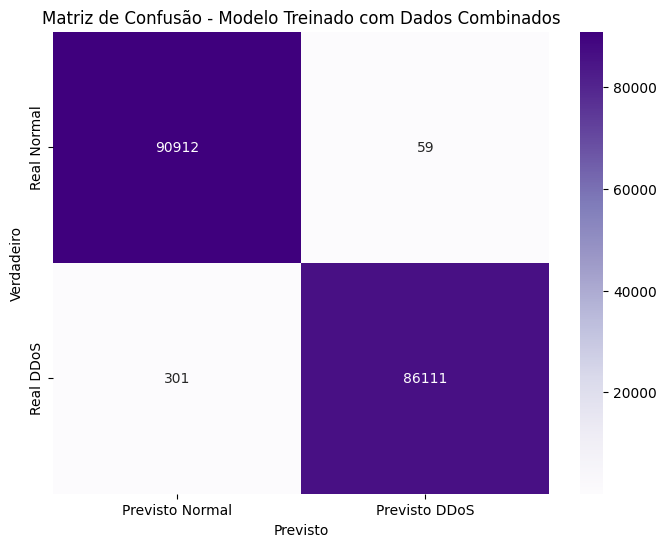

In [10]:
# 1. Combinar os dois DataFrames (o de treino original e o de validação)
# ignore_index=True é importante para criar um novo índice contínuo
df_combined = pd.concat([df, df1], ignore_index=True)
print(f"DataFrames combinados. O novo dataset completo tem {df_combined.shape[0]} linhas.")

# 2. Embaralhar (Shuffle) o DataFrame combinado
# Este é um passo CRÍTICO para garantir que os dados de treino e teste sejam representativos
# de ambos os cenários de ataque.
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)
print("Dataset combinado foi embaralhado para garantir a aleatoriedade dos dados.")

# 3. Preparar os novos dados combinados para o modelo
X_combined = df_combined.drop('target', axis=1)
y_combined = df_combined['target']

# 4. Criar uma NOVA divisão de treino/teste a partir dos dados combinados
# Usamos stratify=y_combined para manter a proporção de ataques/normais nos conjuntos
print("\nDividindo o dataset combinado em novos conjuntos de treino e teste...")
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)
print(f"Novos dados divididos em {len(X_train_comb)} amostras de treino e {len(X_test_comb)} de teste.")

# 5. Criar e treinar um NOVO pipeline do zero com os dados combinados
# É uma boa prática instanciar um novo modelo para não sobrescrever o anterior
print("\nIniciando o treinamento do novo modelo robusto...")
model_pipeline_combined = Pipeline(
    steps=[
        ("preprocessor", preprocessor), # Reutilizamos o mesmo preprocessor
        ("classifier", DecisionTreeClassifier(max_depth=5, random_state=42)),
    ]
)
model_pipeline_combined.fit(X_train_comb, y_train_comb)
print("Novo modelo treinado com sucesso!")

# 6. Avaliar o novo modelo no seu respectivo conjunto de teste
print("\nRealizando previsões com o novo modelo...")
y_pred_comb = model_pipeline_combined.predict(X_test_comb)

# 7. Exibir os resultados do modelo robusto
print("\n--- RESULTADOS DO MODELO ROBUSTO (TREINADO COM DADOS COMBINADOS) ---")
accuracy_comb = accuracy_score(y_test_comb, y_pred_comb)
print(f"\nACURÁCIA DO NOVO MODELO: {accuracy_comb * 100:.2f}%")

print("\nRelatório de Classificação do Novo Modelo:")
print(classification_report(y_test_comb, y_pred_comb, target_names=["Normal", "DDoS"]))

print("Gerando a Matriz de Confusão do Novo Modelo...")
cm_comb = confusion_matrix(y_test_comb, y_pred_comb)
plt.figure(figsize=(8, 6))
# Usar uma nova cor (ex: 'Purples') para diferenciar o gráfico
sns.heatmap(
    cm_comb,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["Previsto Normal", "Previsto DDoS"],
    yticklabels=["Real Normal", "Real DDoS"],
)
plt.title("Matriz de Confusão - Modelo Treinado com Dados Combinados")
plt.ylabel("Verdadeiro")
plt.xlabel("Previsto")
plt.show()


--- 2. Validando o Modelo ROBUSTO em 'validation_data.csv' ---
Acurácia do Modelo ROBUSTO em 'validation_data.csv': 100.00%


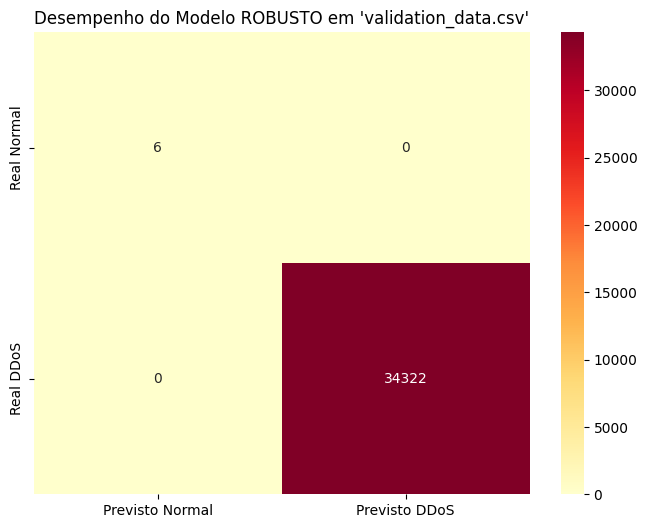

In [11]:
# Teste com o Modelo Robusto
X_new_val = df1.drop('target', axis=1)
y_new_val = df1['target']

print("\n--- 2. Validando o Modelo ROBUSTO em 'validation_data.csv' ---")
y_pred_new_combined = model_pipeline_combined.predict(X_new_val)
accuracy_new_combined = accuracy_score(y_new_val, y_pred_new_combined)
print(f"Acurácia do Modelo ROBUSTO em 'validation_data.csv': {accuracy_new_combined * 100:.2f}%")
cm_new_combined = confusion_matrix(y_new_val, y_pred_new_combined)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new_combined, annot=True, fmt="d", cmap="YlOrRd", xticklabels=["Previsto Normal", "Previsto DDoS"], yticklabels=["Real Normal", "Real DDoS"])
plt.title("Desempenho do Modelo ROBUSTO em 'validation_data.csv'")
plt.show()


Gerando a visualização da Árvore de Decisão...


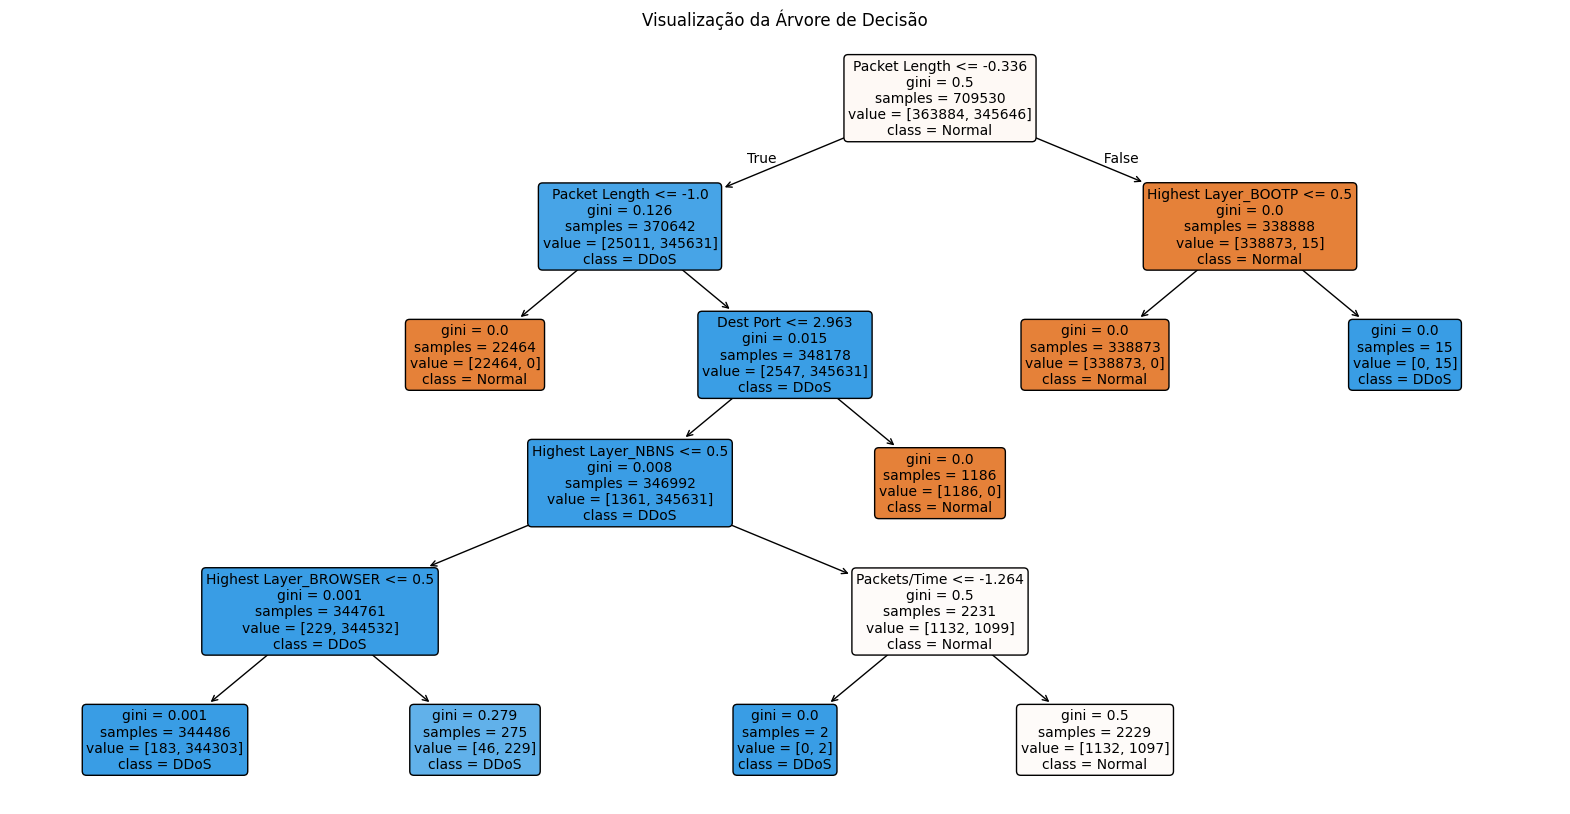

In [12]:
print("\nGerando a visualização da Árvore de Decisão...")

# Pegar os nomes das features após o OneHotEncoding para usar no gráfico
feature_names = numeric_features + list(
    model_pipeline_combined.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)

plt.figure(figsize=(20, 10))
plot_tree(
    model_pipeline_combined.named_steps["classifier"],
    feature_names=feature_names,
    class_names=["Normal", "DDoS"],
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("Visualização da Árvore de Decisão")
plt.show()


######################################################################
###       TESTE FINAL: VALIDANDO OS MODELOS COM attack_data_ml.csv      ###
######################################################################

--- 1. Validando o Modelo ORIGINAL em 'attack_data_ml.csv' ---
Acurácia do Modelo ORIGINAL em 'attack_data_ml.csv': 10.91%


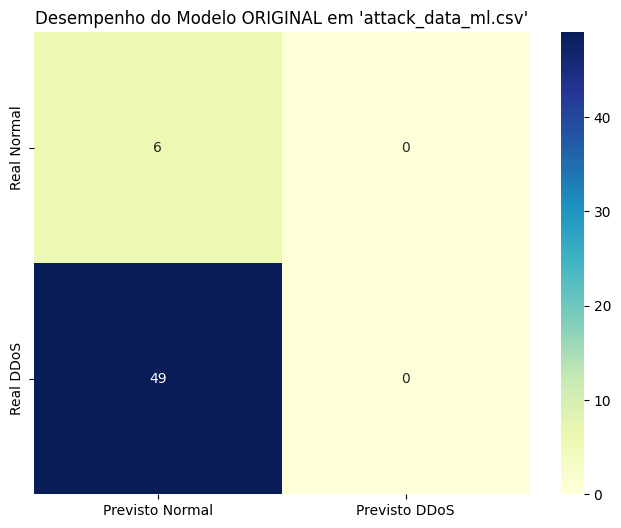


--- 2. Validando o Modelo ROBUSTO em 'attack_data_ml.csv' ---
Acurácia do Modelo ROBUSTO em 'attack_data_ml.csv': 100.00%


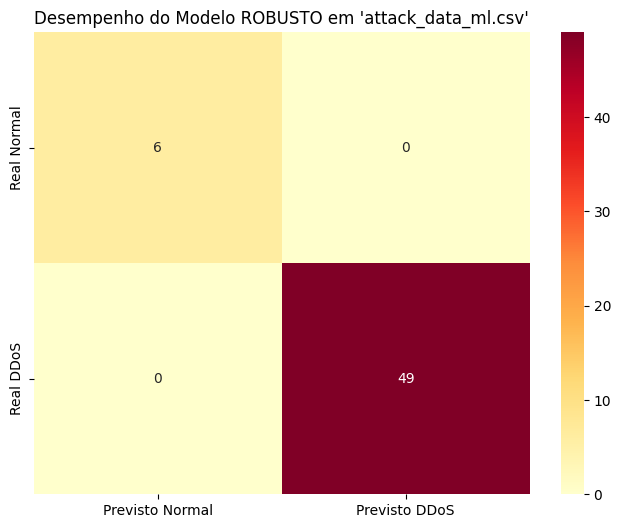

In [13]:
# ==============================================================================
# == ETAPA 6: VALIDAÇÃO FINAL USANDO 'attack_data_ml.csv' (AGORA CORRIGIDO)
# ==============================================================================
print("\n" + "#"*70)
print("###       TESTE FINAL: VALIDANDO OS MODELOS COM attack_data_ml.csv      ###")
print("#"*70 + "\n")

X_new_val = df2.drop('target', axis=1)
y_new_val = df2['target']

# Teste com o Modelo Original
print("--- 1. Validando o Modelo ORIGINAL em 'attack_data_ml.csv' ---")
y_pred_new_original = model_pipeline.predict(X_new_val)
accuracy_new_original = accuracy_score(y_new_val, y_pred_new_original)
print(f"Acurácia do Modelo ORIGINAL em 'attack_data_ml.csv': {accuracy_new_original * 100:.2f}%")
cm_new_original = confusion_matrix(y_new_val, y_pred_new_original)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new_original, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Previsto Normal", "Previsto DDoS"], yticklabels=["Real Normal", "Real DDoS"])
plt.title("Desempenho do Modelo ORIGINAL em 'attack_data_ml.csv'")
plt.show()

# Teste com o Modelo Robusto
print("\n--- 2. Validando o Modelo ROBUSTO em 'attack_data_ml.csv' ---")
y_pred_new_combined = model_pipeline_combined.predict(X_new_val)
accuracy_new_combined = accuracy_score(y_new_val, y_pred_new_combined)
print(f"Acurácia do Modelo ROBUSTO em 'attack_data_ml.csv': {accuracy_new_combined * 100:.2f}%")
cm_new_combined = confusion_matrix(y_new_val, y_pred_new_combined)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new_combined, annot=True, fmt="d", cmap="YlOrRd", xticklabels=["Previsto Normal", "Previsto DDoS"], yticklabels=["Real Normal", "Real DDoS"])
plt.title("Desempenho do Modelo ROBUSTO em 'attack_data_ml.csv'")
plt.show()